In [1]:
# Import SQLAlchemy and other dependencies 
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
import datetime as dt
import pandas as pd
import matplotlib
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt
from sqlalchemy import Column, Integer, String, Float, Text, ForeignKey
import numpy as np

# Reflect Tables into SQLAlchemy ORM

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [4]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table

inspector = inspect(engine)
inspector.get_table_names()
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [6]:
# Create our session (link) from Python to the DB

Station = Base.classes.station
Measurements = Base.classes.measurement
session = Session(engine)

# Exploratory Climate Analysis

2016-08-23
('2017-08-23',)


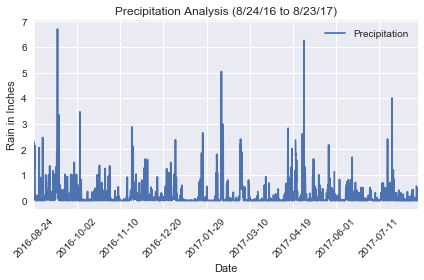

In [7]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)


# Calculate the date 1 year ago from the last data point in the database

last_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
print(last_date)

# Perform a query to retrieve the data and precipitation scores

rain = session.query(Measurements.date, Measurements.prcp).\
    filter(Measurements.date > last_year).\
    order_by(Measurements.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(rain)
rain_df.head()


# Sort the dataframe by date

rain_df.set_index('date').head()

# Use Pandas Plotting with Matplotlib to plot the data


rain_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis (8/24/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [9]:
# Design a query to show how many stations are available in this dataset?

locations = session.query(Measurements).group_by(Measurements.station).count()
print("There are {} stations.".format(locations))

There are 9 stations.


In [10]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


results = session.query(Measurements.station, func.count(Measurements.station)).\
group_by(Measurements.station).\
order_by(func.count(Measurements.station).desc()).all()
results


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [11]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


most_active = results[0][0]
targets = [func.min(Measurements.tobs), func.max(Measurements.tobs), func.avg(Measurements.tobs)]
session.query(*targets).all()



[(53.0, 87.0, 73.09795396419437)]

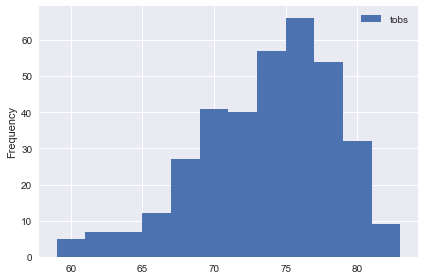

In [23]:

# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

prev_year = dt.date(2017, 8, 18) - dt.timedelta(days=365)

data = session.query(Measurements.tobs).filter(Measurements.station == "USC00519281").\
filter(Measurements.date >= prev_year).all()


#----------------------------------------------------------------
#THREE DIFF WAYS TO SAVE THE DATA AND PLOT IT

#df = pd.DataFrame(data)
# plt.hist(df["tobs"], bins=12, label='tobs')

# d_list = []
# data1 = np.ravel(data)
# for d in data1:
#     d_list.append(d)


# data1 = np.ravel(data)
# data1 = list(data1)
#----------------------------------------------------------------

#Create empty list
d_list = []
#Place data in flattened array
new_data = np.ravel(data)
#Append new data to a list
save_data = [d_list.append(d) for d in new_data]
#Plot
plt.hist(d_list, bins=12, label='tobs')
plt.legend()
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [13]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).filter(Measurements.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [14]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


results = calc_temps("2016-06-30", "2016-07-06")
results


[(71.0, 77.125, 82.0)]

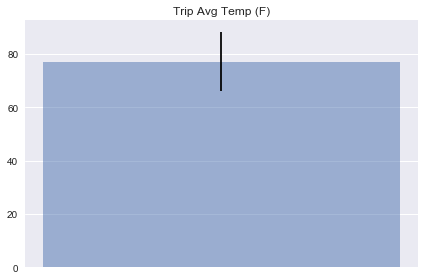

In [15]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots()
title = "Trip Avg Temp (F)"
error = results[0][2] - results[0][0]
plt.bar(0, results[0][1], yerr=error, align='center', alpha=0.5, ecolor='black', capsize=5)
plt.title(title)
plt.xticks([],[])
plt.tight_layout()
plt.savefig(f"{title}.png")
plt.show()

In [16]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

target = [Measurements.station, Station.name,\
          Station.latitude, Station.longitude,\
          Station.elevation,\
          func.avg(Measurements.prcp)]

results = session.query(*target).\
filter(Measurements.date < "2017-07-06").\
filter(Measurements.date > "2016-06-30").\
group_by(Measurements.station).\
order_by(func.avg(Measurements.prcp).desc()).all()

print(results)

[('USC00516128', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.5071428571428497), ('USC00519281', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.25129729729729555), ('USC00513117', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.17094594594594462), ('USC00519523', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.1420312500000001), ('USC00514830', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.13342412451361826), ('USC00517948', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.08365079365079357), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.06341530054644826)]


In [17]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurements.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [18]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates
trip_dates = pd.date_range("2017-07-15", "2017-07-20")

# Strip off the year and save a list of %m-%d strings
date_strings = trip_dates.strftime('%m-%d')
#-----------------------------------------
#ALTERNATE WAY OF DOING IT

# date_strings = []
# for date in trip_dates:
#     date_strings.append(date[5:10])
#-----------------------------------------


# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in date_strings:
    normals.append(daily_normals(date))
    
print(normals)

[[(68.0, 76.2542372881356, 82.0)], [(70.0, 76.34482758620689, 83.0)], [(70.0, 76.30188679245283, 83.0)], [(72.0, 76.63793103448276, 83.0)], [(68.0, 75.89090909090909, 83.0)], [(69.0, 75.46296296296296, 82.0)]]


In [19]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

index = trip_dates
df = pd.DataFrame(index=index, columns=["tmin", "tavg", "tmax"])
df.index.name = "date"

for x in range(len(normals)):
    df.loc[index[x], "tmin"] = normals[x][0][0]
    df.loc[index[x], "tavg"] = normals[x][0][1]
    df.loc[index[x], "tmax"] = normals[x][0][2]
df


,tmin,tavg,tmax
date,,,
2017-07-15,68,76.2542,82
2017-07-16,70,76.3448,83
2017-07-17,70,76.3019,83
2017-07-18,72,76.6379,83
2017-07-19,68,75.8909,83
2017-07-20,69,75.463,82


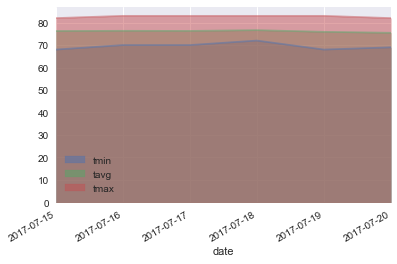

In [20]:
# Plot the daily normals as an area plot with `stacked=False`


df.plot.area(x_compat=True, stacked=False)
